In [1]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import tqdm
# import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os

In [2]:
IMG_SIZE = 299
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [3]:
IMG_EMBED_SIZE = 2048
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = 1
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

In [4]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
#     word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    word_embed = L.Embedding(8769, WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(8769)
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits` layer
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth =tf.reshape(sentences[:,1:],[-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))### YOUR CODE HERE ###

In [5]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())


/Users/valeriakaravaeva/Documents/git/_LK/app_image_captioning/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("data/weights/weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /Users/valeriakaravaeva/Documents/git/_LK/app_image_captioning/data/weights/weights


In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import queue
import threading
import zipfile
import tqdm
import cv2
import numpy as np
import pickle


def image_center_crop(img):
    h, w = img.shape[0], img.shape[1]
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = 0
    if h > w:
        diff = h - w
        pad_top = diff - diff // 2
        pad_bottom = diff // 2
    else:
        diff = w - h
        pad_left = diff - diff // 2
        pad_right = diff // 2
    return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]


def decode_image_from_buf(buf):
    img = cv2.imdecode(np.asarray(bytearray(buf), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def crop_and_preprocess(img, input_shape, preprocess_for_model):
    img = image_center_crop(img)  # take center crop
    img = cv2.resize(img, input_shape)  # resize for our model
    img = img.astype("float32")  # prepare for normalization
    img = preprocess_for_model(img)  # preprocess for model
    return img


def apply_model(zip_fn, model, preprocess_for_model, extensions=(".jpg",), input_shape=(224, 224), batch_size=32):
    # queue for cropped images
    q = queue.Queue(maxsize=batch_size * 10)

    # when read thread put all images in queue
    read_thread_completed = threading.Event()

    # time for read thread to die
    kill_read_thread = threading.Event()

    def reading_thread(zip_fn):
        zf = zipfile.ZipFile(zip_fn)
        for fn in tqdm.tqdm_notebook(zf.namelist()):
            if kill_read_thread.is_set():
                break
            if os.path.splitext(fn)[-1] in extensions:
                buf = zf.read(fn)  # read raw bytes from zip for fn
                img = decode_image_from_buf(buf)  # decode raw bytes
                img = crop_and_preprocess(img, input_shape, preprocess_for_model)
                while True:
                    try:
                        q.put((os.path.split(fn)[-1], img), timeout=1)  # put in queue
                    except queue.Full:
                        if kill_read_thread.is_set():
                            break
                        continue
                    break

        read_thread_completed.set()  # read all images

    # start reading thread
    t = threading.Thread(target=reading_thread, args=(zip_fn,))
    t.daemon = True
    t.start()

    img_fns = []
    img_embeddings = []

    batch_imgs = []

    def process_batch(batch_imgs):
        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_embeddings = model.predict(batch_imgs)
        img_embeddings.append(batch_embeddings)

    try:
        while True:
            try:
                fn, img = q.get(timeout=1)
            except queue.Empty:
                if read_thread_completed.is_set():
                    break
                continue
            img_fns.append(fn)
            batch_imgs.append(img)
            if len(batch_imgs) == batch_size:
                process_batch(batch_imgs)
                batch_imgs = []
            q.task_done()
        # process last batch
        if len(batch_imgs):
            process_batch(batch_imgs)
    finally:
        kill_read_thread.set()
        t.join()

    q.join()

    img_embeddings = np.vstack(img_embeddings)
    return img_embeddings, img_fns


def save_pickle(obj, fn):
    with open(fn, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def read_pickle(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)


In [11]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [2]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == 0:
            break
       
    return list(map(vocab_inverse.get, caption))


# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

In [12]:
import pickle

vocab_inverse = pickle.load(open("data/vocab_inverse.pkl", "rb"))

/Users/valeriakaravaeva/Documents/git/_LK/app_image_captioning/venv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a woman holding a cell phone in a kitchen


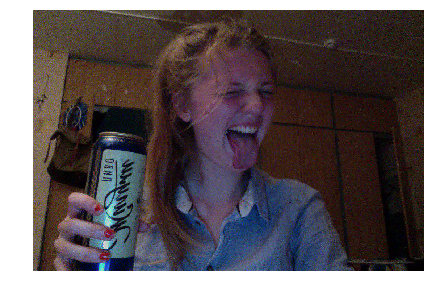

In [14]:
apply_model_to_image_raw_bytes(open("data/image/1.jpg", "rb").read())